
# Recommender Systems with Python


In [94]:
# Loading in packages

import pandas as pd
import numpy as np
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import make_column_transformer

import warnings
warnings.filterwarnings("ignore")

We will be using the common MovieLens dataset to focus on content-based and collaborative-filtering based reccommendation systems. The dataset has over 100,000 records of movies, user ratings, and genres of movies. You can find additional MovieLens datasets through the following link: https://grouplens.org/datasets/movielens/

In [95]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

The movies dataframe includes the titles of popular movies and their genres in a pipe-seperated list.

In [96]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The ratings dataframe includes the ratings of popular movies based on movieId.

In [97]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Merging the movies and ratings dataframe to relate and connect each rating to its respective movie.

In [98]:
df = movies.merge(ratings, on='movieId')

## Content-Based Recommendations

Recall: Content-based recommendations are based on item-similarity. User feedback to specific content will relay that user to related and similar content.  

#### Cosine Similarity

To calculate similarity between items *m* and *b* you use the formula:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?s_u^{cos}(i_m,i_b)=\frac{i_m&space;\cdot&space;i_b&space;}{&space;\left&space;\|&space;i_m&space;\right&space;\|&space;\left&space;\|&space;i_b&space;\right&space;\|&space;}&space;=\frac{\sum&space;x_{a,m}x_{a,b}}{\sqrt{\sum&space;x_{a,m}^2\sum&space;x_{a,b}^2}}
"/>

Where i represents the event space of the feature in question.

#### An NLP Approach

Recall that content-based reccomendation systems recommend similar content to the content that the user interacts with. We can combine and compute similar items based on their natural language characteristics. We can leverage the Term Frequency Inverse Document Frequency (TFID( algorithm to compute similairities in genres for movies. 

More on TFID: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


A quick example of TFID application:

From: [TD-IDF Vectorizer, Mukesh Chaudhary](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a)

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [100]:
train = ['The sky is blue.','The sun is bright.']
test = ['The sun in the sky is bright', 'We can see the shining sun, the bright sun.']

tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words= 'english')
tfidf_wm = tfidfvectorizer.fit_transform(train)

tfidf_tokens = tfidfvectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = ['Doc1','Doc2'], columns = tfidf_tokens)
df_tfidfvect

,blue,bright,sky,sun
Doc1,0.707107,0.000000,0.707107,0.000000
Doc2,0.000000,0.707107,0.000000,0.707107


We can apply the TfidfVectorizer to the genre column in our movies dataframe to interprete common genres within movies and build reccommendations based on such results.

In [101]:
# Cleaning up pipe-seperated list
movies['genres'] = (movies['genres'].apply(lambda genres : genres.replace('|', ', ')))

In [102]:
tfidf = TfidfVectorizer(analyzer='word', stop_words= 'english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Viewing compiled matrix
view_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names())
view_matrix['title']= movies['title']

In [103]:
# Defining cosine similarity for each movie in relation to each other
# Linear kernel represents vector distance
cos_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [104]:
# Computing cosine similarity for the first movie
toyStoryScores = list(enumerate(cos_similarity[0]))

In [105]:
# Sorting the returned list
toyStoryScores = sorted(toyStoryScores, key=lambda x: x[1], reverse = True)

In [106]:
# Acquiring top 10 similar movies based on genre
toyStorySimilarMovies = toyStoryScores[1:11]
toyStorySimilarMovies = [toyStorySimilarMovies[i][0] for i in range(len(toyStorySimilarMovies))]

In [107]:
movies.iloc[toyStorySimilarMovies]['title']

1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object

## Collaborative Filtering Recommendations

Recall: Content-based recommendations are based on user-to-user preferences. An engine produces recommendations based on the knowledge of users’ attitude to items and the similarity of other user preferences.

### A Naïve Approach

Let's create an aggregated dataframe of each movie and the sum of their ratings.

In [108]:
cf_df = df.drop(columns=['genres', 'timestamp'])
cf_df

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5
...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),184,4.0
100832,193583,No Game No Life: Zero (2017),184,3.5
100833,193585,Flint (2017),184,3.5
100834,193587,Bungo Stray Dogs: Dead Apple (2018),184,3.5


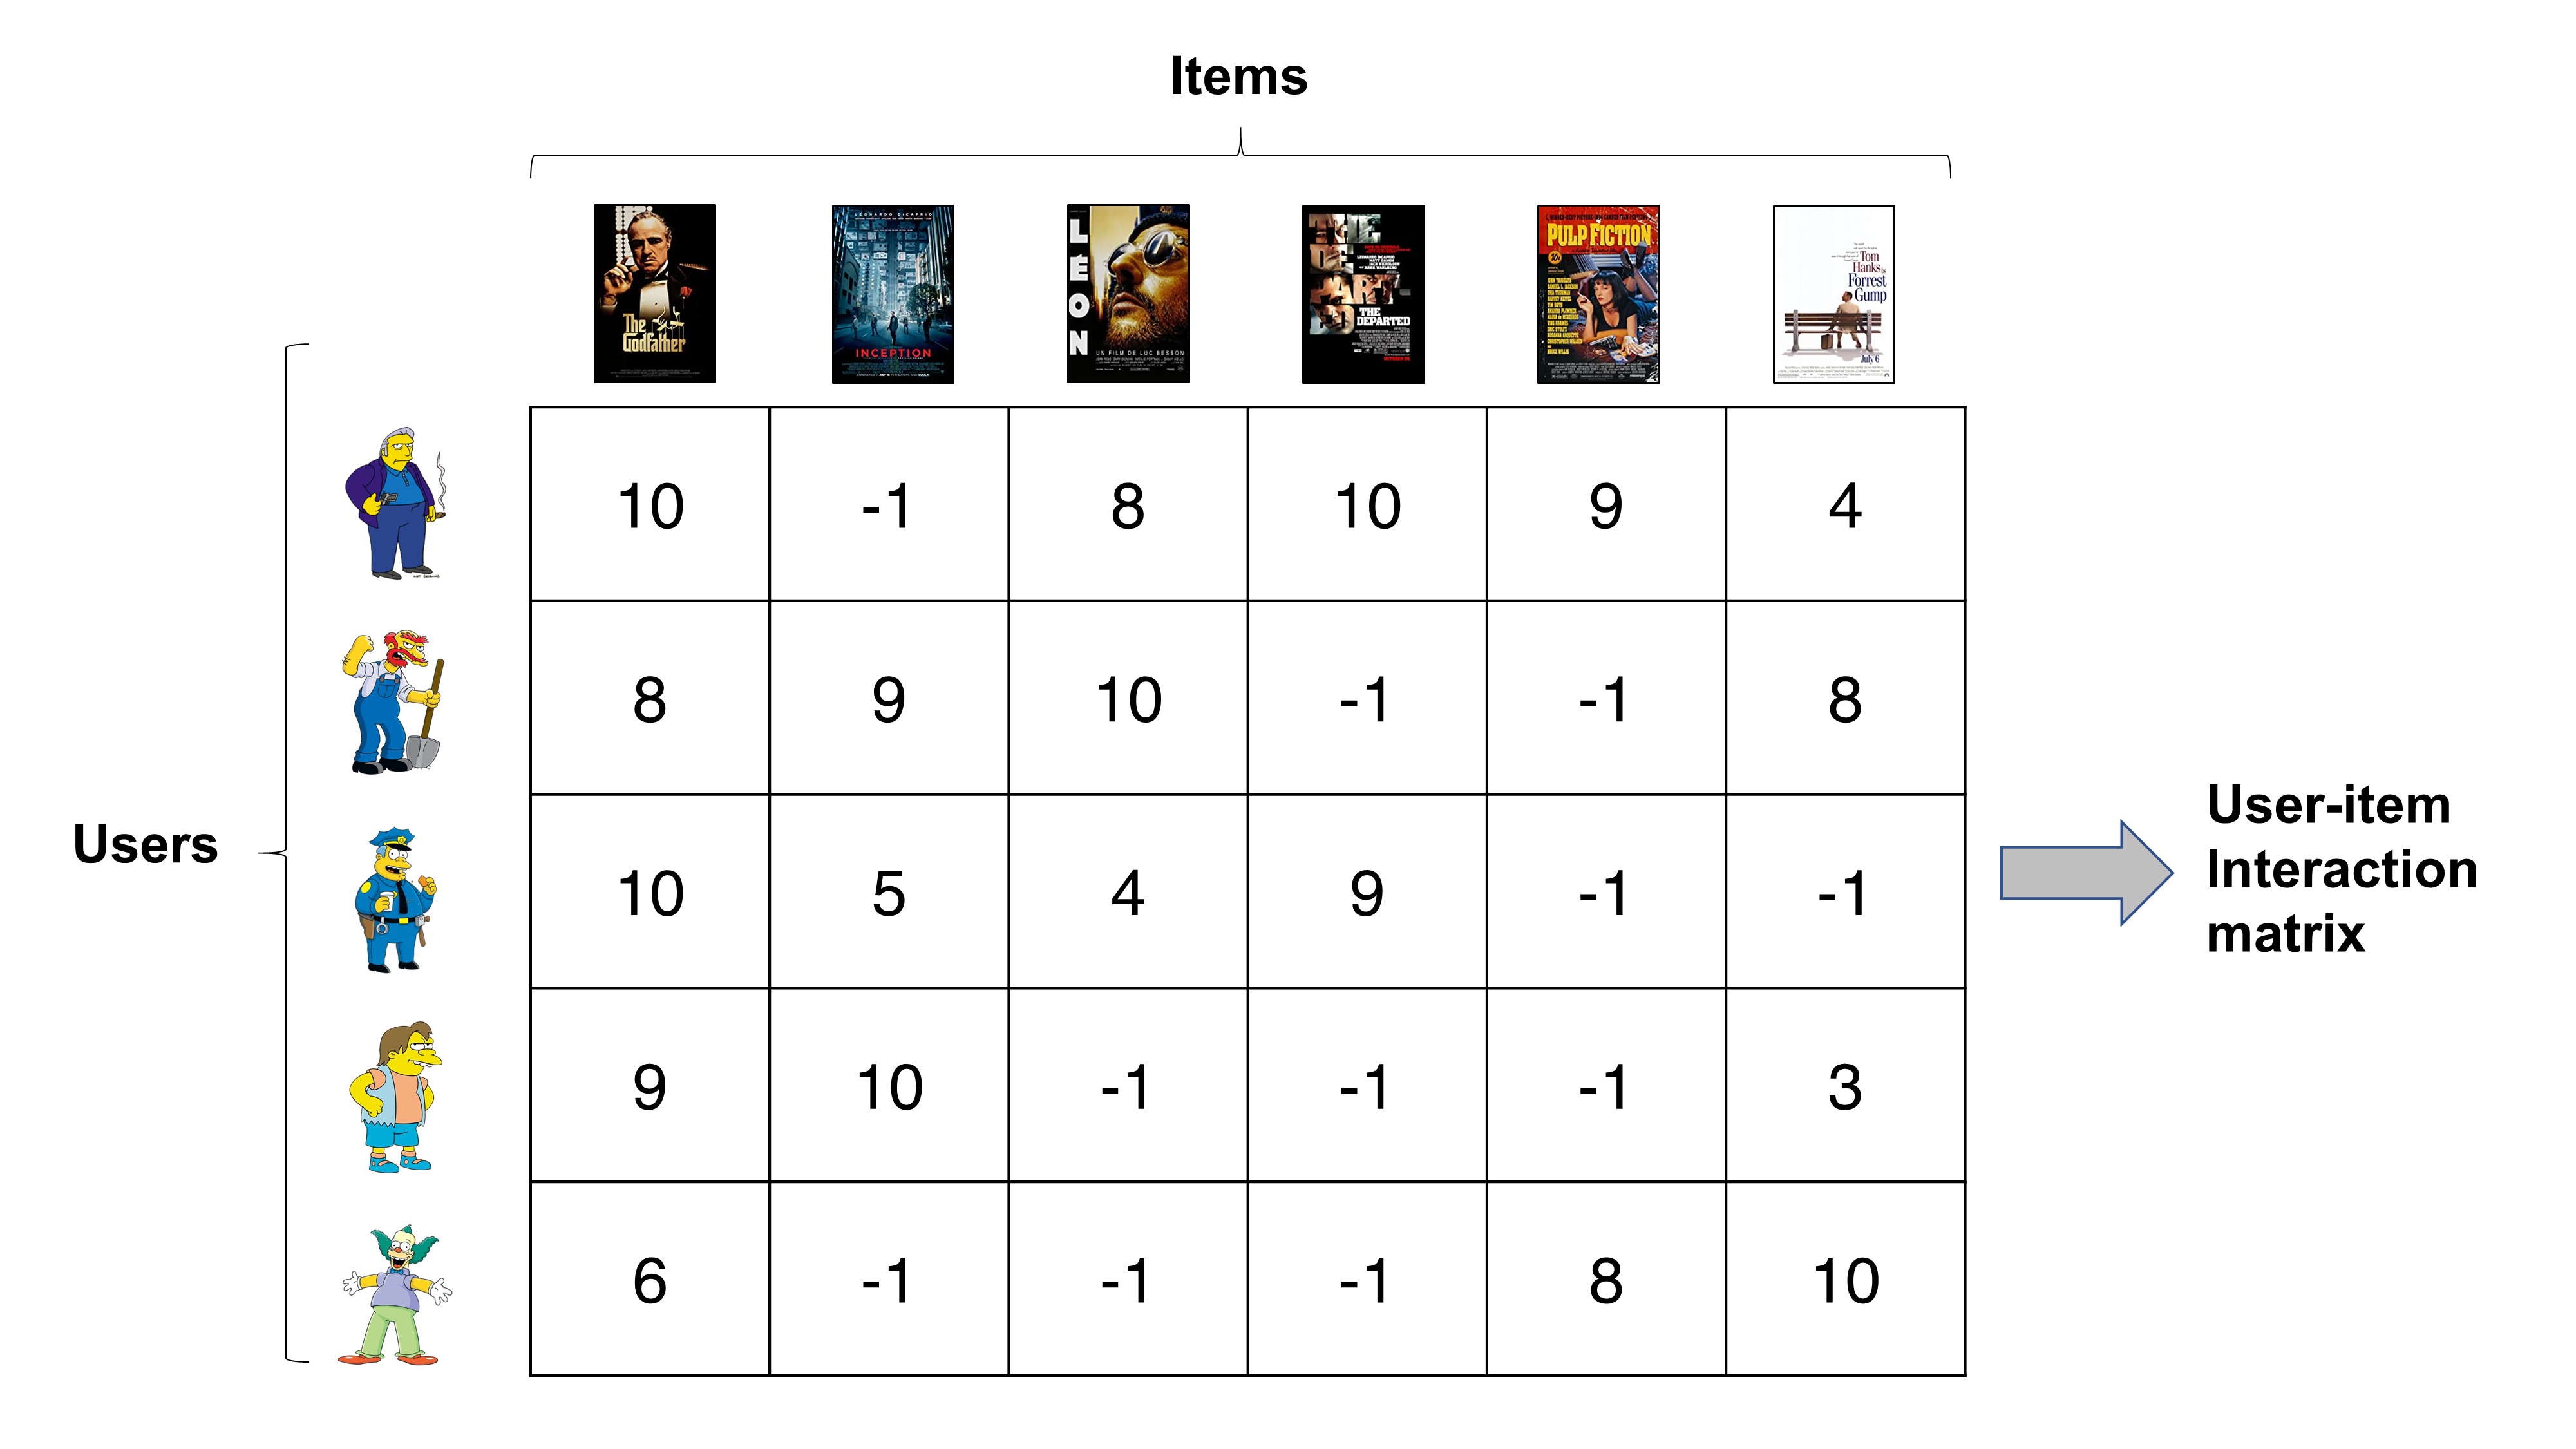

In [109]:
cf_matrix = cf_df.pivot_table(index = ["userId"], columns = ["title"], values = "rating")

In [110]:
cf_matrix.tail(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
610,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,...,NaN,4.0,3.5,3.0,NaN,NaN,2.0,1.5,NaN,NaN


In [111]:
cf_matrix['Toy Story (1995)']

userId
1      4.0
2      NaN
3      NaN
4      NaN
5      4.0
      ... 
606    2.5
607    4.0
608    2.5
609    3.0
610    5.0
Name: Toy Story (1995), Length: 610, dtype: float64

In [112]:
cf_matrix['Toy Story (1995)']

userId
1      4.0
2      NaN
3      NaN
4      NaN
5      4.0
      ... 
606    2.5
607    4.0
608    2.5
609    3.0
610    5.0
Name: Toy Story (1995), Length: 610, dtype: float64

In [113]:
# Leveraging Panda's Built-In Correlation Metric
# Computing similiarity 
similarity_scores = cf_matrix.corrwith(cf_matrix['Toy Story (1995)'])

In [114]:
similarity_scores

title
'71 (2014)                                        NaN
'Hellboy': The Seeds of Creation (2004)           NaN
'Round Midnight (1986)                            NaN
'Salem's Lot (2004)                               NaN
'Til There Was You (1997)                         NaN
                                               ...   
eXistenZ (1999)                              0.333282
xXx (2002)                                  -0.244733
xXx: State of the Union (2005)               0.129969
¡Three Amigos! (1986)                       -0.387202
À nous la liberté (Freedom for Us) (1931)         NaN
Length: 9719, dtype: float64

In [115]:
similarity_scores.sort_values(ascending = False)[0:11]

title
Land Before Time III: The Time of the Great Giving (1995)    1.0
Orlando (1992)                                               1.0
Goosebumps (2015)                                            1.0
Encounters at the End of the World (2008)                    1.0
Suburban Commando (1991)                                     1.0
Bad Words (2013)                                             1.0
Escaflowne: The Movie (Escaflowne) (2000)                    1.0
Opera (1987)                                                 1.0
Evening with Kevin Smith 2: Evening Harder, An (2006)        1.0
Everybody Wants Some (2016)                                  1.0
Cabaret (1972)                                               1.0
dtype: float64

#### K-Nearest Neighbor Algorithm

"An algorithm which classifies a new data point based on it's proximity to other data point groups."

[K-Nearest Neighbors Algorithm Example](https://towardsdatascience.com/understanding-and-using-k-nearest-neighbours-aka-knn-for-classification-of-digits-a55e00cc746f#:~:text=It%20is%20an%20algorithm%20which,getting%20classified%20into%20that%20group.)

In [116]:
df.drop(columns = ['timestamp'], inplace=True)

In [118]:
df.drop_duplicates(['title','userId'],inplace=True)
df

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5
...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5
100833,193585,Flint (2017),Drama,184,3.5
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5


In [119]:
user_rating_pivot=df.pivot_table(columns='userId',index='title',values='rating')

In [120]:
user_rating_pivot.sample(5)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
Luxo Jr. (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bedknobs and Broomsticks (1971),5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN
Bulletproof Monk (2003),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2.0
Eve's Bayou (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fist of Legend (Jing wu ying xiong) (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For computational purposes, we want to convert NaN values to zero.

In [121]:
user_rating_pivot.fillna(0,inplace=True)

Using sparse matrices to store data that contains a large number of zero-valued elements can both save a significant amount of memory and speed up the processing of that data.

Seeing as the data contains a large number of zero-valued elements, we can save memory and processing speed by converting the matrix to a sparse 

In [122]:
from scipy.sparse import csr_matrix
movies_sparsed = csr_matrix(movie_pivot)

In [123]:
print(movies_sparsed[0])

  (0, 609)	4.0


In [124]:
movie_sparse

<9719x610 sparse matrix of type '<class 'numpy.float64'>'
	with 100832 stored elements in Compressed Sparse Row format>

In [125]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(n_neighbors=7, algorithm='brute', metric='cosine')

In [126]:
model.fit(movie_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=7)

In [131]:
distances,suggestions = model.kneighbors(movie_pivot.iloc[540,:].values.reshape(1,-1))

In [128]:
def reco(movie_name):
    movie_id = df[df['title']==movie_name]['movieId'].values[0]
    distances,suggestions=model.kneighbors(movie_pivot.iloc[1,:].values.reshape(1,-1))
    for i in range(len(suggestions)):
        return (movie_pivot.index[suggestions[i]])

In [129]:
for movie in reco("Toy Story (1995)"):
    print(movie)

Space Battleship Yamato (2010)
Monsters (2010)
'Hellboy': The Seeds of Creation (2004)
All the Right Moves (1983)
Hidden Fortress, The (Kakushi-toride no san-akunin) (1958)
...And Justice for All (1979)
'Round Midnight (1986)
